## Dependencies

All the dependencies for this notebook are included in the `requirements.txt` file included in this folder.


In [40]:
from radiant_mlhub import Collection
import tarfile
import os
from pathlib import Path
import json

import geopandas as gpd
import datetime
import rasterio
import numpy as np
import pandas as pd
import elevation
import shapely

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from rasterio.plot import show

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedShuffleSplit

from IPython.display import clear_output

In [42]:
fields_train_mean_var = pd.read_csv('data/mean_var_8days_train.csv')
#fields_train_mean_var2 = pd.read_csv('fields_train_mean_var_data2.csv')
#fields_train_mean_var3 = pd.read_csv('fields_train_mean_var_data3.csv')
fields_train_mean_var

,field_id,label,tile_id,elevation,field_area_km2,geometry,neighboor_label_1,neighboor_label_2,neighboor_label_3,neighboor_label_4,...,B06_VAR_7,B07_VAR_7,B08_VAR_7,B09_VAR_7,B11_VAR_7,B12_VAR_7,B8A_VAR_7,VEG_IDX_VAR_7,MOIST_IDX_VAR_7,NDVI_IDX_VAR_7
0,3020,2,2587,197.333333,0.001702,"POLYGON ((18.572953 -33.570726, 18.572933 -33....",0.153001,0.433001,0.016667,0.020899,...,3.439446,8.242215,8.415225,0.228374,3.474048,2.837370,3.584775,0.000160,0.001123,0.000160
1,99466,2,2587,173.574074,0.042403,"POLYGON ((18.575171 -33.572303, 18.575128 -33....",0.153001,0.433001,0.016667,0.020899,...,139.848856,140.055514,165.293432,82.640864,100.025003,127.354436,136.891059,0.000846,0.019817,0.000846
2,15902,5,2587,149.222222,0.029503,"POLYGON ((18.580872 -33.572594, 18.580869 -33....",0.153001,0.433001,0.016667,0.020899,...,34.787544,36.935754,53.602804,40.073312,60.294513,143.805573,41.244861,0.001510,0.013808,0.001510
3,38846,3,2587,89.761364,0.069601,"POLYGON ((18.598422 -33.572846, 18.598419 -33....",0.153001,0.433001,0.016667,0.020899,...,437.590963,435.460455,480.509141,325.472742,504.214970,984.098956,383.185064,0.026636,66.265450,0.026636
4,87981,1,2587,90.272727,0.022603,"POLYGON ((18.591885 -33.587145, 18.591862 -33....",0.153001,0.433001,0.016667,0.020899,...,25.782598,22.703579,40.416889,7.707416,39.147721,41.700779,20.353845,0.001584,0.005817,0.001584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87108,97927,5,1379,12.648810,0.132305,"POLYGON ((18.324705 -32.555242, 18.324702 -32....",0.000000,0.034213,0.084855,0.039216,...,83.466128,86.497704,93.542228,143.851307,111.682417,134.670082,84.793754,0.000560,1820.754096,0.000560
87109,47177,5,1379,18.692308,0.020899,"POLYGON ((18.327992 -32.555673, 18.32799 -32.5...",0.000000,0.034213,0.084855,0.039216,...,112.877407,111.158627,97.236693,194.203200,142.296834,185.621758,106.495318,0.000345,228.991022,0.000345
87110,92107,5,2198,351.913907,0.123286,"POLYGON ((18.795047 -31.881489, 18.795045 -31....",0.000000,0.000000,0.119177,0.000000,...,50.627817,48.777843,57.483780,34.343136,23.595141,22.030777,43.819613,0.000131,0.003467,0.000131
87111,93104,5,2198,370.108014,0.229515,"POLYGON ((18.79496 -31.880676, 18.794952 -31.8...",0.000000,0.000000,0.119177,0.000000,...,56.857862,54.892323,61.551993,38.887556,27.336124,24.459045,50.392906,0.000131,0.002988,0.000131


In [33]:
#fields_train_mean_var = fields_train_mean_var.drop('neighboor_label_sun_rate', axis=1)

In [39]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, log_loss

X = fields_train_mean_var.drop(['field_id', 'label', 'geometry', 'tile_id'], axis=1)
y = fields_train_mean_var.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=fields_train_mean_var.label)

In [57]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
print(model)

AdaBoostClassifier()


In [58]:
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

              precision    recall  f1-score   support

           1       0.38      0.12      0.19      1756
           2       0.48      0.32      0.38      2839
           3       0.37      0.18      0.25      1653
           4       0.72      0.96      0.82      5302
           5       0.37      0.36      0.37      1689
           6       0.35      0.15      0.21      1761
           7       0.43      0.42      0.42      2269
           8       0.10      0.51      0.16       302
           9       0.39      0.82      0.53       910

    accuracy                           0.50     18481
   macro avg       0.40      0.43      0.37     18481
weighted avg       0.49      0.50      0.47     18481

Cross-Entropy-Loss:  2.094254281832271


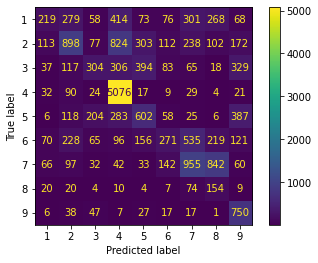

In [59]:
print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(model, X_test, y_test)
### print("Cross-Entropy-Loss:  " + str(log_loss(y_test, y_test_pred_proba, labels=y_test)))

              precision    recall  f1-score   support

           1       0.39      0.19      0.25      1756
           2       0.46      0.47      0.46      2839
           3       0.38      0.38      0.38      1653
           4       0.76      0.91      0.83      5302
           5       0.32      0.25      0.28      1689
           6       0.28      0.17      0.21      1761
           7       0.56      0.64      0.60      2269
           8       0.10      0.16      0.12       302
           9       0.30      0.45      0.36       910

    accuracy                           0.53     18481
   macro avg       0.40      0.40      0.39     18481
weighted avg       0.50      0.53      0.51     18481

Cross-Entropy-Loss:  2.1365860226465894


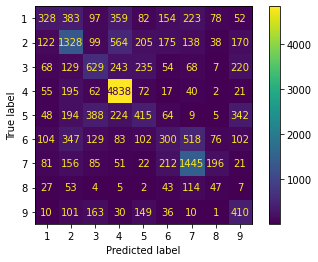

In [68]:
"""
Drop all features except for the image Data
"""

X = fields_train_mean_var.drop(['field_id', 'label', 'geometry', 'elevation', 'neighboor_label_1', 'neighboor_label_2','neighboor_label_3',
                                'neighboor_label_4','neighboor_label_5', 'neighboor_label_6','neighboor_label_7', 'neighboor_label_8', 'neighboor_label_9', 'sun_rate'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=fields_train_mean_var.label)

model = AdaBoostClassifier()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(model, X_test, y_test)
print("Cross-Entropy-Loss:  " + str(log_loss(y_test, y_test_pred_proba, labels=y_test)))

              precision    recall  f1-score   support

           1       0.30      0.13      0.18      1756
           2       0.36      0.41      0.38      2839
           3       0.44      0.20      0.28      1653
           4       0.66      0.87      0.75      5302
           5       0.40      0.31      0.35      1689
           6       0.29      0.12      0.17      1761
           7       0.40      0.45      0.42      2269
           8       0.06      0.06      0.06       302
           9       0.33      0.71      0.45       910

    accuracy                           0.47     18481
   macro avg       0.36      0.36      0.34     18481
weighted avg       0.44      0.47      0.44     18481

Cross-Entropy-Loss:  2.1172735094892903


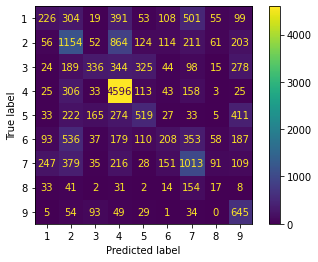

In [70]:
"""
Use all features except image data
"""

X = fields_train_mean_var[['sun_rate', 'elevation', 'neighboor_label_1', 'neighboor_label_2','neighboor_label_3',
                                'neighboor_label_4','neighboor_label_5', 'neighboor_label_6','neighboor_label_7', 'neighboor_label_8', 'neighboor_label_9']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=fields_train_mean_var.label)

model = AdaBoostClassifier()
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)

print(classification_report(y_test, y_test_pred))
plot_confusion_matrix(model, X_test, y_test)
print("Cross-Entropy-Loss:  " + str(log_loss(y_test, y_test_pred_proba, labels=y_test)))

In [2]:
"""
Cheap NN
"""

from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout      # create layers

np.random.seed(42)
tf.random.set_seed(42)

Using TensorFlow backend.


NameError: name 'np' is not defined

In [48]:
X = fields_train_mean_var.drop(['field_id', 'label', 'geometry', 'tile_id', 'elevation'], axis=1)
y = fields_train_mean_var.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42, stratify=fields_train_mean_var.label)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

print(y_train_onehot.shape)
print(y_test_onehot.shape)

(86241, 10)
(872, 10)


In [49]:
X.shape

(87113, 251)

In [1]:
# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 256, kernel_initializer = 'HeUniform', activation = 'relu', input_dim = 251))
model.add(Dropout(0.3))
model.add(Dense(units = 256, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 16, kernel_initializer = 'HeUniform', activation = 'relu'))
model.add(Dense(units = 10, kernel_initializer = 'HeUniform'))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])
print(model.summary())

NameError: name 'Sequential' is not defined

In [59]:
training = model.fit(X_train, y_train_onehot, batch_size = 500, validation_split=0.2, epochs = 50, verbose=2)

Epoch 1/50
138/138 - 4s - loss: 0.9201 - accuracy: 0.6785 - val_loss: 0.8590 - val_accuracy: 0.6894
Epoch 2/50
138/138 - 3s - loss: 0.9161 - accuracy: 0.6785 - val_loss: 0.8561 - val_accuracy: 0.6909
Epoch 3/50
138/138 - 4s - loss: 0.9049 - accuracy: 0.6816 - val_loss: 0.8514 - val_accuracy: 0.6932
Epoch 4/50
138/138 - 3s - loss: 0.8971 - accuracy: 0.6833 - val_loss: 0.8430 - val_accuracy: 0.6935
Epoch 5/50
138/138 - 4s - loss: 0.8898 - accuracy: 0.6876 - val_loss: 0.8442 - val_accuracy: 0.6969
Epoch 6/50
138/138 - 3s - loss: 0.8859 - accuracy: 0.6877 - val_loss: 0.8400 - val_accuracy: 0.6962
Epoch 7/50
138/138 - 3s - loss: 0.8747 - accuracy: 0.6937 - val_loss: 0.8368 - val_accuracy: 0.6984
Epoch 8/50
138/138 - 4s - loss: 0.8679 - accuracy: 0.6938 - val_loss: 0.8334 - val_accuracy: 0.6998
Epoch 9/50
138/138 - 3s - loss: 0.8647 - accuracy: 0.6946 - val_loss: 0.8313 - val_accuracy: 0.7029
Epoch 10/50
138/138 - 3s - loss: 0.8593 - accuracy: 0.6955 - val_loss: 0.8274 - val_accuracy: 0.7022

In [54]:
y_test_pred_proba = model.predict(X_test)

In [55]:
pd.DataFrame(y_test_pred_proba[:20,:].round(5))

,0,1,2,3,4,5,6,7,8,9
0,0.00000,0.24600,0.39038,0.01519,0.01531,0.01029,0.39420,0.04963,0.00754,0.00214
1,0.00000,0.04093,0.00359,0.00062,0.00015,0.00025,0.06691,0.79442,0.27129,0.00001
2,0.00000,0.49563,0.11210,0.00622,0.00052,0.00258,0.35765,0.02732,0.01460,0.00074
3,0.00000,0.00210,0.00912,0.00345,0.99974,0.00182,0.00009,0.00011,0.00000,0.00000
4,0.00000,0.00049,0.00061,0.00088,0.99999,0.00036,0.00000,0.00000,0.00000,0.00000
5,0.00000,0.10267,0.81977,0.02793,0.00204,0.48075,0.08943,0.00484,0.00123,0.00145
6,0.00033,0.20380,0.26567,0.24220,0.03071,0.68972,0.13104,0.04415,0.01611,0.02561
7,0.00000,0.07923,0.02677,0.00449,0.00605,0.00240,0.19895,0.86526,0.04992,0.00021
8,0.00001,0.43368,0.40759,0.09953,0.21068,0.15325,0.01681,0.00986,0.00219,0.00117
9,0.00000,0.33723,0.92997,0.03225,0.10817,0.06813,0.01016,0.00605,0.00071,0.00020


In [12]:
y_test_pred = y_test_pred_proba.argmax(axis=-1)

In [13]:
print("Cross-Entropy-Loss:  " + str(log_loss(y_test_onehot, y_test_pred_proba, labels=y_test_onehot)))

Cross-Entropy-Loss:  0.8035676814391689


In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           1       0.60      0.63      0.61      2502
           2       0.66      0.66      0.66      4175
           3       0.58      0.61      0.59      2374
           4       0.93      0.94      0.93      7268
           5       0.60      0.51      0.55      2441
           6       0.55      0.49      0.52      2475
           7       0.80      0.84      0.82      3214
           8       0.79      0.53      0.63       448
           9       0.65      0.79      0.71      1237

    accuracy                           0.73     26134
   macro avg       0.68      0.67      0.67     26134
weighted avg       0.72      0.73      0.72     26134



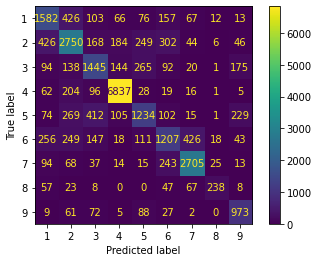

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred, labels=[1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5,6,7,8,9])
disp.plot()

In [20]:
y_test_pred_proba.shape

(26134, 10)

In [27]:
fields_test_mean_var = pd.read_csv('data/mean_var_8days_test.csv')

In [28]:
X_VAL = fields_test_mean_var.drop(['field_id', 'geometry', 'tile_id', 'elevation'], axis=1)

In [29]:
X_VAL.shape

(35295, 251)

In [56]:
X_VAL = scaler.transform(X_VAL)

In [57]:
X_VAL_predict_proba = model.predict(X_VAL)

In [148]:
X_VAL_predict_proba.shape

(X_VAL_predict_proba[3,:]/np.linalg.norm(X_VAL_predict_proba[3,:])).round(2)

array([0.  , 0.17, 0.41, 0.03, 0.02, 0.04, 0.64, 0.61, 0.17, 0.  ],
      dtype=float32)

In [149]:
X_VAL_predict_normal = np.zeros(X_VAL_predict_proba.shape)

for i in range(X_VAL_predict_proba.shape[0]):
    
    x = X_VAL_predict_proba[i,:]
    X_VAL_predict_normal[i,:] = x / np.sum(x)
    
df_sol_proba = pd.DataFrame(X_VAL_predict_normal.round(2))

In [150]:
df_sol =  pd.concat([fields_test_mean_var['field_id'],df_sol_proba], axis =1)

In [151]:
df_sol

,field_id,0,1,2,3,4,5,6,7,8,9
0,62027,0.0,0.04,0.14,0.01,0.01,0.01,0.33,0.42,0.04,0.0
1,62071,0.0,0.17,0.71,0.01,0.01,0.03,0.06,0.01,0.00,0.0
2,85373,0.0,0.06,0.31,0.02,0.02,0.03,0.30,0.21,0.05,0.0
3,102896,0.0,0.08,0.20,0.01,0.01,0.02,0.31,0.29,0.08,0.0
4,3079,0.0,0.11,0.80,0.01,0.01,0.03,0.04,0.01,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
35290,117413,0.0,0.36,0.58,0.00,0.01,0.01,0.02,0.00,0.00,0.0
35291,16515,0.0,0.23,0.62,0.01,0.07,0.02,0.04,0.01,0.00,0.0
35292,59992,0.0,0.29,0.61,0.01,0.03,0.01,0.04,0.01,0.00,0.0
35293,61236,0.0,0.10,0.04,0.66,0.13,0.04,0.01,0.01,0.00,0.0


In [152]:
df_sol = df_sol[["field_id", 8, 3, 1,2,9,6,5,7,4]]
column_names = {"field_id": "Field ID",8:"Crop_Canola",3:"Crop_Fallow",1:"Crop_Lucerne/Medics",2:"Crop_Planted pastures (perennial)",9:"Crop_Rooibos",6:"Crop_Small grain grazing",5:"Crop_Weeds",7:"Crop_Wheat",4:"Crop_Wine grapes"}

df_sol_clean = df_sol.rename(columns = column_names)
df_sol_clean.head()

,Field ID,Crop_Canola,Crop_Fallow,Crop_Lucerne/Medics,Crop_Planted pastures (perennial),Crop_Rooibos,Crop_Small grain grazing,Crop_Weeds,Crop_Wheat,Crop_Wine grapes
0,62027,0.04,0.01,0.04,0.14,0.0,0.33,0.01,0.42,0.01
1,62071,0.00,0.01,0.17,0.71,0.0,0.06,0.03,0.01,0.01
2,85373,0.05,0.02,0.06,0.31,0.0,0.30,0.03,0.21,0.02
3,102896,0.08,0.01,0.08,0.20,0.0,0.31,0.02,0.29,0.01
4,3079,0.00,0.01,0.11,0.80,0.0,0.04,0.03,0.01,0.01


In [154]:
df_sol_clean.to_csv("Submission_1.csv", index=False)